In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

class PositionalNoiseEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, sigma):
        device = sigma.device # sigma is noise level

        half_dim = self.embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = sigma[:, None] * emb[None, :]  # (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # (B, embedding_dim)
        return emb

class UNetDDPMpp(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=128):
        super().__init__()
        # Time embedding
        # self.time_embed = PositionalNoiseEmbedding(time_emb_dim)
        # self.time_emb_proj1 = nn.Linear(time_emb_dim, out_channels)
        # self.time_emb_proj2 = nn.Linear(time_emb_dim, out_channels)
        # self.time_emb_proj3 = nn.Linear(time_emb_dim, out_channels * 2)
    
        #encoder
        self.encoder1 = self.convolution_block(in_channels, out_channels)
        self.encoder2 = self.convolution_block(out_channels, out_channels*2)

        # Bottleneck
        self.bottleneck = self.convolution_block(out_channels * 2, out_channels * 4)

        #decoder
        self.decoder2 = self.up_block(out_channels * 4, out_channels * 2)
        self.decoder1 = self.up_block(out_channels * 2, out_channels)

        # Final output
        self.last_conv = nn.Conv2d(out_channels, 1, kernel_size=1)

    def convolution_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            self.convolution_block(out_c * 2, out_c)
        )  
    
    def forward(self, x):
        # return x_pred  
        # # Predicted noise 
        # # maybe need time embedding
        # t_emb = self.time_embed(sigma)  # [batch, time_emb_dim]

        # # Inject time embedding into each stage
        # emb1 = self.time_emb_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        # emb2 = self.time_emb_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        # emb3 = self.time_emb_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)

        enc1 = self.encoder1(x)

        enc2 = self.encoder2(F.max_pool2d(enc1, 2) )
        
        b = self.bottleneck(F.max_pool2d(enc2, 2))

        d2 = self.decoder2[0](b)
        d2 = self.decoder2[1](torch.cat([d2, enc2], dim=1))

        d1 = self.decoder1[0](d2)
        d1 = self.decoder1[1](torch.cat([d1, enc1], dim=1))

        return self.last_conv(d1)
    


#### test
model = UNetDDPMpp()
x = torch.randn(2, 3, 128, 128)  # batch_size=1, 1 channel, 128x128 image
sigma = torch.randn(x.shape[0])   # Random noise schedule for batch size 1

y = model(x)
print(y.shape)  # Output: torch.Size([1, 1, 128, 128])





torch.Size([2, 1, 128, 128])


In [ ]:
class Denoiser(nn.Module):
    def __init__(self, unet, M=1000):
        super().__init__()
        self.unet = unet
        self.M = M

    def get_precondition(self):
        sigma = torch.tensor([0.1, 0.5])  

        sigma = sigma.view(-1, 1, 1, 1)  # Shape: [B, 1, 1, 1]
        c_skip = torch.ones_like(sigma) 
        c_out = -sigma
        c_in = 1 / (torch.sqrt(sigma**2 + 1))

        c_noise = (self.M - 1) * sigma**(-1)  # Inverse sigma
        return c_skip, c_out, c_in, c_noise

    def denoise(self, x):
        c_skip, c_out, c_in, c_noise = self.get_precondition()

        c_in = c_in.view(-1, 1, 1, 1)
        c_out = c_out.view(-1, 1, 1, 1)
        c_skip = c_skip.view(-1, 1, 1, 1)
        c_noise = c_noise.view(-1, 1, 1, 1)

        # t_emb = self.unet.time_embed(sigma)  # [B, time_emb_dim]

        x_in = c_in * x
        predicted_noise = self.unet(x_in)

        x_denoised = c_skip * x + c_out * predicted_noise
        return x_denoised

    def forward(self, x):  # ✅ This line makes it work with model(x, sigma)
        return self.denoise(x)
        


In [19]:
unet_model = UNetDDPMpp()
denoiser = Denoiser(unet_model)

#test
x = torch.randn(2, 3, 128, 128)  # Noisy input
# batch of noise levels

# Denoise the image
denoised = denoiser.denoise(x)
print(denoised.shape)  # Should be [2, 1, 128, 128]


torch.Size([2, 3, 128, 128])


In [ ]:
# Forward process
def beta_t(t, beta_min=0.1, beta_max=20.0):
    return beta_min + t * (beta_max - beta_min)

def get_zigma_vp(t, beta_d=19.9, beta_min=0.1):
    t = torch.tensor(t)
    zigma = torch.sqrt(torch.exp(0.5*beta_d * t**2 + beta_min*t) - 1)
    return zigma

def get_time_step(i, steps):
    epsilon_s = 0.001
    time_step =  epsilon_s +  (i * (1 - epsilon_s))/(steps - 1)
    # in sampling its different
    return time_step

def simulate_vp_sde(x0, steps=100, beta_min=0.1, beta_max=20.0):
    x = x0.clone()
    B, C, H, W = x.shape
    dt = 1.0 / steps
    images = [x0.cpu()] 

    for i in range(steps):
        # t = torch.tensor(i / steps).to(x.device)
        # beta = beta_t(t, beta_min, beta_max)

        t = get_time_step(i, steps)
        print('t', t)
        beta = get_zigma_vp(t)
        
        noise = torch.randn_like(x)
        
        drift = -0.5 * beta * x * dt
        diffusion = (beta * dt).sqrt() * noise
        
        x = x + drift + diffusion
        images.append(x.cpu())

    return images
def show_images(images, every=10):
    n = len(images)
    indices = list(range(0, n, every))
    fig, axs = plt.subplots(1, len(indices), figsize=(15, 3))
    for ax, i in zip(axs, indices):
        img = images[i][0].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize
        ax.imshow(img)
        ax.set_title(f"Step {i}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:

def print_img_fwd_process(img):
    # img = Image.open('../dog.jpg').convert('RGB')
    transform = T.Compose([
        T.Resize((128, 128)),         # or 128x128 etc., match your model
        T.ToTensor(),               # Converts to [0, 1]
        T.Normalize(0.5, 0.5)       # Maps to [-1, 1]
    ])
    x0 = transform(img).unsqueeze(0).to('cpu')

    noisy_mg = simulate_vp_sde(x0, steps=100)
    show_images(noisy_mg, every=10)

t 0.001
t 0.011090909090909092
t 0.021181818181818184
t 0.03127272727272727
t 0.041363636363636366
t 0.051454545454545454
t 0.06154545454545454
t 0.07163636363636364
t 0.08172727272727273
t 0.09181818181818181
t 0.10190909090909091
t 0.112
t 0.12209090909090908
t 0.13218181818181818
t 0.14227272727272727
t 0.15236363636363637
t 0.16245454545454546
t 0.17254545454545456
t 0.18263636363636362
t 0.19272727272727275
t 0.20281818181818181
t 0.2129090909090909
t 0.223
t 0.2330909090909091
t 0.24318181818181817
t 0.25327272727272726
t 0.26336363636363636
t 0.27345454545454545
t 0.28354545454545454
t 0.29363636363636364
t 0.30372727272727273
t 0.31381818181818183
t 0.3239090909090909
t 0.33399999999999996
t 0.3440909090909091
t 0.3541818181818182
t 0.36427272727272725
t 0.3743636363636364
t 0.3844545454545455
t 0.39454545454545453
t 0.4046363636363636
t 0.4147272727272728
t 0.4248181818181818
t 0.4349090909090909
t 0.445
t 0.4550909090909091
t 0.4651818181818182
t 0.4752727272727273
t 0.485363

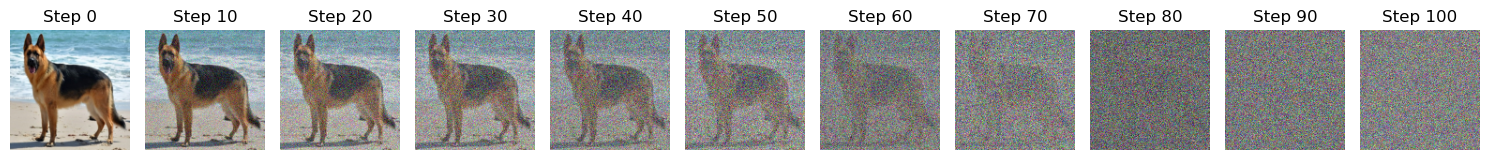

In [ ]:
img = Image.open('../dog.jpg')
print_img_fwd_process(img)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
device = 'cpu'
model = UNetDDPMpp().to(device)
denoiser = Denoiser(model)

optimizer = optim.Adam(model.parameters(), lr=2e-4)

mse_loss = nn.MSELoss()

beta_d = 19.9
beta_min = 0.1
epsilon_t = 1e-5

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

epochs = 5
for epoch in range(epochs):
    model.train()
    pbar = tqdm(loader)
    total_loss = 0

    for x, _ in pbar:
        x = x.to(device)
        B = x.size(0)

        t = torch.rand(B, device=x.device) * (1.0 - epsilon_t) + epsilon_t

        sigma = torch.sqrt(torch.exp(0.5 * beta_d * t ** 2 + beta_min * t) - 1)
        sigma = sigma.view(-1, 1, 1, 1)

        noise = torch.randn_like(x)
        x_noisy = x + sigma * noise

        pred = denoiser(x_noisy, sigma.view(-1))  # sigma input to Denoiser

        loss = (1 / (sigma ** 2)) * (pred - noise) ** 2
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
    # Save model and optimizer state after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, f'check_points/checkpoint_epoch_{epoch+1}.pt')

    print(f"[Epoch {epoch+1}] Avg Loss: {total_loss / len(loader):.4f}")

Epoch 1 | Loss: 2.2510: 100%|██████████| 782/782 [00:25<00:00, 30.12it/s]   


[Epoch 1] Avg Loss: 93.9495


Epoch 2 | Loss: 1.2548: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]   


[Epoch 2] Avg Loss: 61.5827


Epoch 3 | Loss: 12.7770: 100%|██████████| 782/782 [00:27<00:00, 28.40it/s]  


[Epoch 3] Avg Loss: 61.2151


Epoch 4 | Loss: 2.5402: 100%|██████████| 782/782 [00:26<00:00, 29.01it/s]   


[Epoch 4] Avg Loss: 74.6073


Epoch 5 | Loss: 1.1640: 100%|██████████| 782/782 [00:27<00:00, 28.21it/s]   

[Epoch 5] Avg Loss: 61.0963


In [ ]:
# Load your model
model2 = UNetDDPMpp().to(device)
denoiser2 = Denoiser(model2)  # Assuming your Denoiser wraps the UNet

# Load weights
checkpoint = torch.load("checkpoint_epoch_5.pt", map_location=device)
model2.load_state_dict(checkpoint['model_state_dict'])
model2.eval()


UNetDDPMpp(
  (time_embed): PositionalNoiseEmbedding()
  (time_emb_proj1): Linear(in_features=128, out_features=3, bias=True)
  (time_emb_proj2): Linear(in_features=128, out_features=3, bias=True)
  (time_emb_proj3): Linear(in_features=128, out_features=6, bias=True)
  (encoder1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder2): Sequential(
    (

In [ ]:
@torch.no_grad()
def sample_edm_vp(denoiser, shape, steps=1000, epsilon_s=1e-3, beta_d=19.9, beta_min=0.1):
    x = torch.randn(shape).to(next(denoiser.parameters()).device)  # Start from noise
    for i in reversed(range(steps)):
        # Convert to tensor
        t = epsilon_s + (i * (1 - epsilon_s)) / (steps - 1)
        t_tensor = torch.tensor(t, dtype=torch.float32).to(x.device)

        sigma = torch.sqrt(torch.exp(0.5 * beta_d * t_tensor ** 2 + beta_min * t_tensor) - 1)
        sigma_tensor = torch.full((shape[0],), sigma.item(), dtype=torch.float32).to(x.device)

        # Euler step: dt = (σ_i^2 - σ_{i-1}^2)
        if i > 0:
            t_prev = epsilon_s + ((i - 1) * (1 - epsilon_s)) / (steps - 1)
            t_prev_tensor = torch.tensor(t_prev, dtype=torch.float32).to(x.device)
            sigma_prev = torch.sqrt(torch.exp(0.5 * beta_d * t_prev_tensor ** 2 + beta_min * t_prev_tensor) - 1)
        else:
            sigma_prev = torch.tensor(0.0, dtype=torch.float32).to(x.device)

        # Score estimate via denoising
        denoised = denoiser.denoise(x, sigma_tensor)

        # Euler update step
        d_sigma_sq = sigma**2 - sigma_prev**2
        x = x + (d_sigma_sq / sigma) * (x - denoised)

    return x

sample_edm_vp(denoiser2, shape=(1, 3, 128, 128), steps=100)

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])